# 

In [25]:
# Cào Data từ https://bonbanh.com/oto

In [27]:
# C1: https://bonbanh.com/oto/page,4: Mỗi trang nó có 1 cái url: /page,4 => Làm cái vòng for, tăng URL lên là được

In [29]:
# C2: Kích hoạt Event sang trang của nút Next, cào lần lượt (Mất tg hơn) 
# Ý tưởng: Ấn Next -> Lấy ra URL -> Load Url -> lẤY DATA: VVVVV (Ko dùng được kiểu nnày rồi, vì nút Next ko để ID, class thì trùng với nút khác)

In [124]:
# I. Cào Data
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import time

start_url = "https://bonbanh.com/oto/page,"

count_page = 0
max_page = 501

data = []

for i in range(2, max_page + 1):
    current_url = start_url + str(i)
    print(f"Đang cào trang {i}: {current_url}")
    html = requests.get(current_url).text
    soup = BeautifulSoup(html, "html5lib")

    list_car = soup.find_all("li", class_="car-item")

    for car in list_car:
        # Lấy dữ liệu
        year = car.select_one(".cb1 b")
        name = car.select_one("h3[itemprop='name']")
        status_tag = car.select_one(".cb1")
        status = ""
        if status_tag:
            text = status_tag.get_text(strip=True)
            if "Xe cũ" in text:
                status = "Cũ"
            elif "Xe mới" in text:
                status = "Mới"
            else:
                status = "Cũ"
        else:
            status = None
        price_tag = car.select_one("b[itemprop='price']")
        currency = car.select_one("meta[itemprop='priceCurrency']")
        loc = car.select_one(".cb4 b")
        img = car.select_one("img.h-car-img")
        code = car.select_one(".car_code")

        # Xly description
        desc_tag = car.select_one(".cb6_02")
        car_type = color = engine = transmission = seats = mileage = None
        desc_text = None
        if desc_tag:
            # Lấy toàn bộ text
            full_text = desc_tag.get_text(" ", strip=True)
        
            # Tách phần đầu (trước khi xuống dòng hoặc có <p>)
            first_line = full_text.split("Anh")[0]  # cắt trước phần mô tả sau
            desc_text = full_text  # lưu toàn bộ phần mô tả gốc nếu cần
        
            # --- Bắt các dữ liệu cụ thể ---
            # car_type
            match = re.search(r"^\*?\s*(Xe[^\.,]+)", first_line)
            if match:
                car_type = match.group(1).strip()

        
            # color
            match = re.search(r"màu\s+(\w+)", first_line)
            if match:
                color = match.group(1).capitalize()
        
            # engine (ví dụ: "máy xăng 1.5 L")
            match = re.search(r"máy\s+([^\s,]+)\s+([\d\.]+)\s*L", first_line)
            if match:
                engine = f"{match.group(1)} {match.group(2)}L"
        
            # transmission
            match = re.search(r"(số\s+[^\s,\.]+(?:\s+[^\s,\.]+)?)", first_line)
            if match:
                transmission = match.group(1).strip()
        
            # seats
            match = re.search(r"(\d+)\s*chỗ", first_line)
            if match:
                seats = int(match.group(1))
        
            # mileage
            match = re.search(r"đã đi\s*([\d,\.]+)", first_line)
            if match:
                mileage = int(match.group(1).replace(",", "").replace(".", ""))

        
        seller = car.select_one(".cb7 b")
        address = car.select_one(".cb7 span")

        
        # Cái SDT này hơi bịp, vì nó lấy hết và nối thành 1 chuỗi :vvv
        phone = None
        phone_block = car.select_one(".cb7")
        if phone_block:
            text = phone_block.get_text(separator=" ", strip=True)
            # Xóa khoảng trắng trong số để regex dễ bắt
            text = text.replace(" ", "")
            phones = re.findall(r"0\d{9,10}", text)
            phone = ", ".join(phones) if phones else None
        
        
        data.append({
            "name": name.get_text(strip=True) if name else None,
            "status": status,
            "year": year.get_text(strip=True) if year else None,
            "price_num": price_tag.get("content") if price_tag and price_tag.has_attr("content") else None,
            "currency": currency.get("content") if currency else None,
            "location": loc.get_text(strip=True) if loc else None,
            "code": code.get_text(strip=True).replace("Mã:", "").strip() if code else None,
            
            "car_type": car_type,
            "color": color,
            "engine": engine,
            "transmission": transmission,
            "seats": seats,
            "mileage": mileage,
            "desc": desc_text,
            
            "seller": seller.get_text(strip=True) if seller else None,
            "address": address.get_text(strip=True) if address else None,
            "phone": phone,
            "img": img["src"] if img else None,
        })

# --- Lưu thành DataFrame ---
df2 = pd.DataFrame(data)
df2
# Tách cột engine thành fuel_type và engine_capacity
    # Giả sử cột engine có dạng: "engine_xăng 4.6L" hoặc "engine_dầu 2.0L"
df2[['fuel_type', 'engine_capacity']] = df2['engine'].str.extract(r'(xăng|dầu)\s*([\d\.]+)L?')
    # Chuyển engine_capacity sang float
df2['engine_capacity'] = df2['engine_capacity'].astype(float)
    # Loại bỏ tiền tố "engine_" khỏi fuel_type nếu cần
df2['fuel_type'] = df2['fuel_type'].replace({'xăng': 'xăng', 'dầu': 'dầu'})
print(df2[['engine', 'fuel_type', 'engine_capacity']].head(10))
# Xóa cột engine sau khi đã tách
df2 = df2.drop(columns=['engine'])


# --- Xuất ra CSV---
df2.to_csv("bonbanh_rawdata.csv", index=False, encoding="utf-8-sig")
print("Đã lưu bonbanh_rawdata.csv")


Đang cào trang 2: https://bonbanh.com/oto/page,2
Đang cào trang 3: https://bonbanh.com/oto/page,3
Đang cào trang 4: https://bonbanh.com/oto/page,4
Đang cào trang 5: https://bonbanh.com/oto/page,5
Đang cào trang 6: https://bonbanh.com/oto/page,6
Đang cào trang 7: https://bonbanh.com/oto/page,7
Đang cào trang 8: https://bonbanh.com/oto/page,8
Đang cào trang 9: https://bonbanh.com/oto/page,9
Đang cào trang 10: https://bonbanh.com/oto/page,10
Đang cào trang 11: https://bonbanh.com/oto/page,11
Đang cào trang 12: https://bonbanh.com/oto/page,12
Đang cào trang 13: https://bonbanh.com/oto/page,13
Đang cào trang 14: https://bonbanh.com/oto/page,14
Đang cào trang 15: https://bonbanh.com/oto/page,15
Đang cào trang 16: https://bonbanh.com/oto/page,16
Đang cào trang 17: https://bonbanh.com/oto/page,17
Đang cào trang 18: https://bonbanh.com/oto/page,18
Đang cào trang 19: https://bonbanh.com/oto/page,19
Đang cào trang 20: https://bonbanh.com/oto/page,20
Đang cào trang 21: https://bonbanh.com/oto/page

In [140]:
import pandas as pd

# --- Đọc dữ liệu ---
df = pd.read_csv("bonbanh_rawdata.csv")

# --- Kiểm tra trước ---
print("Trước khi xử lý NaN:")
print(df.isna().sum())

# --- Xử lý cột mileage (dữ liệu số) ---
df["mileage"] = pd.to_numeric(df["mileage"], errors="coerce")  # ép kiểu về số, lỗi -> NaN
median_mileage = df["mileage"].median()  # lấy trung vị
df["mileage"] = df["mileage"].fillna(median_mileage)  # điền NaN bằng trung vị


# --- Làm sạch cột year ---
df["year"] = df["year"].astype(str).str.replace(r"[^\d]", "", regex=True)  # Xóa mọi ký tự không phải số
df["year"] = pd.to_numeric(df["year"], errors="coerce")  # Chuyển về dạng số

# --- Các cột text cần xử lý ---
text_columns = ["color", "engine", "transmission", "car_type", "desc", "seller", "address"]

df['desc'] = df['desc'].str.lstrip('*')

# --- Điền NaN bằng giá trị xuất hiện nhiều nhất (mode) ---
for col in text_columns:
    if df[col].isna().sum() > 0:
        mode_value = df[col].mode()
        if not mode_value.empty:
            most_common = mode_value[0]
            df[col] = df[col].fillna(most_common)


# --- Kiểm tra lại ---
print("\nSau khi xử lý NaN:")
print(df.isna().sum())

# --- Lưu lại ---
df.to_csv("bonbanh_clearNaN.csv", index=False, encoding="utf-8-sig")
print("Đã lưu file: bonbanh_clearNaN.csv")


Trước khi xử lý NaN:
name               0
status             0
year               0
price_num          0
currency           0
location           0
code               0
car_type           0
color             12
engine           942
transmission       0
seats              0
mileage         2811
desc               0
seller             0
address            0
phone              0
img                0
dtype: int64
      engine fuel_type  engine_capacity
0  xăng 2.0L      xăng              2.0
1   dầu 2.4L       dầu              2.4
2  xăng 2.0L      xăng              2.0
3   dầu 2.4L       dầu              2.4
4  xăng 6.6L      xăng              6.6
5  xăng 2.0L      xăng              2.0
6   dầu 2.8L       dầu              2.8
7   dầu 2.0L       dầu              2.0
8  xăng 2.0L      xăng              2.0
9  xăng 1.5L      xăng              1.5

Sau khi xử lý NaN:
name               0
status             0
year               0
price_num          0
currency           0
location           0
co

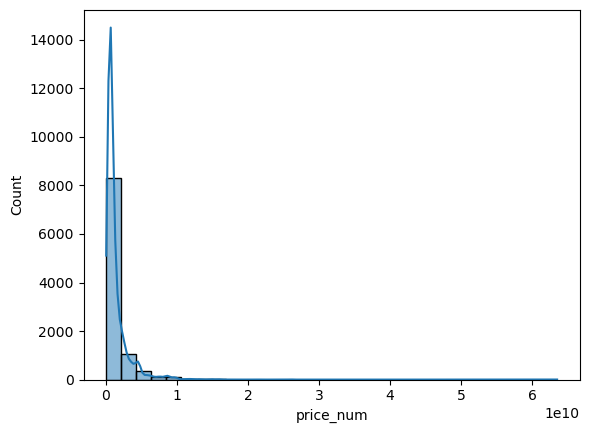

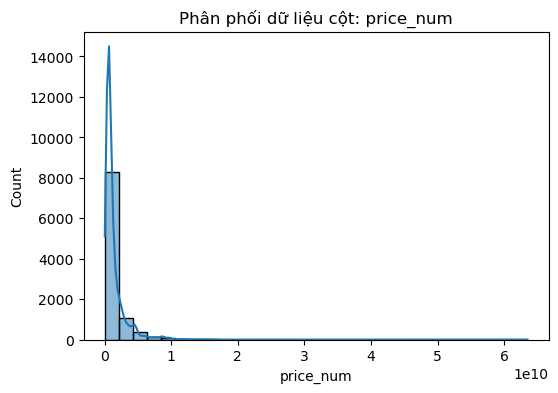

Đã lọc outlier cho 'price_num': 1041 dòng bị loại bỏ.


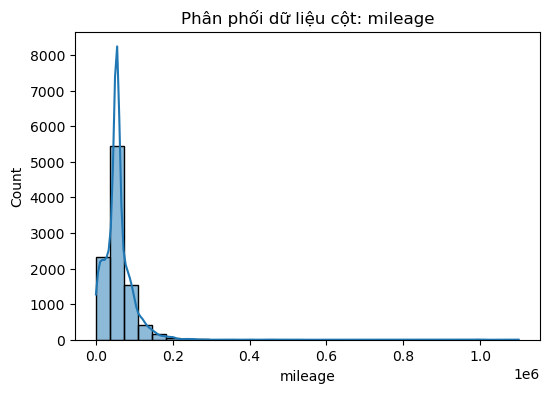

Đã lọc outlier cho 'mileage': 618 dòng bị loại bỏ.
✅ Đã lưu file: bonbanh_filterOutlier.csv


In [142]:
# 2. Xử lý Outlier: 

# ---- Kiểm tra bằng trực quan: vẽ đồ thị ra 
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df["price_num"], bins=30, kde=True)
plt.show() # -> Đồ thị ko đối xứng => ko pbo chuẩn => ko nên dùng z-score hoặc 3-. Nên dùng IQR

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Các cột muốn xử lý ---
columns_to_check = ["price_num", "mileage"]

# --- Tạo bản sao để không mất dữ liệu gốc ---
df_filtered = df.copy()

for col in columns_to_check:
    if col not in df.columns:
        print(f"Bỏ qua '{col}' vì không tồn tại trong DataFrame.")
        continue

    # Kiểm tra trực quan
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Phân phối dữ liệu cột: {col}")
    plt.show()

    # --- Tính IQR ---
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # --- Lọc dữ liệu ---
    before_count = len(df_filtered)
    df_filtered = df_filtered[(df_filtered[col] >= lower) & (df_filtered[col] <= upper)]
    after_count = len(df_filtered)

    print(f"Đã lọc outlier cho '{col}': {before_count - after_count} dòng bị loại bỏ.")

# --- Xuất ra CSV ---
df_filtered.to_csv("bonbanh_filterOutlier.csv", index=False, encoding="utf-8-sig")
print("✅ Đã lưu file: bonbanh_filterOutlier.csv")


In [144]:
import pandas as pd
# 3. KIỂM TRA TRÙNG LẶP 
df3 = pd.read_csv("bonbanh_filterOutlier.csv", encoding="utf-8-sig")
print(f"Đã load {len(df3)} dòng dữ liệu từ bonbanh_filterOutlier.csv")

# Kiểm tra trùng theo mã 'code'
df_duplicate_code = df3[df3.duplicated(subset=["code"], keep=False)]
print(f"Có {len(df_duplicate_code)} bản ghi trùng mã code.")
print(df_duplicate_code[["code", "name", "year", "price_num", "location"]].head())


Đã load 8321 dòng dữ liệu từ bonbanh_filterOutlier.csv
Có 420 bản ghi trùng mã code.
        code                                          name  year   price_num  \
69   6442854                        Peugeot 3008 GT - 2022  2022   840000000   
70   6442854                        Peugeot 3008 GT - 2022  2022   840000000   
136  5814169               BMW X3 xDrive20i M Sport - 2025  2025  2549000000   
137  5814169               BMW X3 xDrive20i M Sport - 2025  2025  2549000000   
151  6443295  Mercedes Benz C class C200 Avantgarde - 2025  2025  1599000000   

    location  
69    Hà Nội  
70    Hà Nội  
136   Hà Nội  
137   Hà Nội  
151   Hà Nội  


In [146]:
df_clean = df3.drop_duplicates(subset=["code"], keep="first")
print(f"Sau khi loại trùng theo mã code: còn {len(df_clean)} bản ghi.")

Sau khi loại trùng theo mã code: còn 8111 bản ghi.


In [148]:
df_clean.to_csv("bonbanh_drop_duplicated.csv", index=False, encoding="utf-8-sig")
print("Đã lưu bonbanh_drop_duplicated.csv (đã loại trùng).")

Đã lưu bonbanh_drop_duplicated.csv (đã loại trùng).
